In [29]:
options(tidyverse.quiet = TRUE)
library(tidyverse)

source("../R/priors.R")
source("../R/functions.R")

In [30]:
# maximal sample size cut-off
nmax             <-  1000
# lowest and highest plausible values of the location parameter theta
prior_lo         <- -1.0
prior_hi         <-  1.0
# range of prior means for location parameter
prior_mean_range <- seq(0, .5, by = .01)
# range of prior standard deviations for location parameter
prior_sd_range   <- seq(.01, 1, by = .01)
# one sided maximal type one error rate
alpha            <- 0.025
# minimal power/expected power/probability of success is 1 - beta
beta             <- 0.2
# upper boundary of the null hypothesis for the location parameter 
# H0: theta <= theta_null
theta_null       <- 0.0
# minimal clinically important difference (MCID)
theta_mcid       <- theta_null

In [31]:
# redifine without rounding
get_n_quantile <- function(null, prior, prob, mrv = null, pwr = .8, alpha = .025, upper_n = 1e4) {
    qnt <- quantile(condition(prior, lo = mrv), 1 - prob)
    f   <- function(n) power(qnt, n, qnorm(1 - alpha)) - pwr
    n   <- tryCatch(
        uniroot(f, lower = 1, upper = upper_n)$root,
        error = function(e) NA_real_
    )
    return(n)
}

get_n_ep <- function(null, prior, mrv = null, pwr = .8, alpha = .025, upper_n = 1e4) {
    f   <- function(n) EP(prior, n, qnorm(1 - alpha)) - pwr
    n   <- tryCatch(
        uniroot(f, lower = 1, upper = upper_n)$root,
        error = function(e) NA_real_
    )
    return(n)
}

match_gamma <- function(n, prior) {
    
    uniroot(
        function(gamma) n - get_n_quantile(theta_null, prior, gamma, pwr = 1 - beta, alpha = alpha, upper_n = 10^4),
        interval = c(0.1, 0.9)
    )
    
}

In [39]:
tbl_grid <- expand_grid(
        mu  = prior_mean_range ,
        tau = prior_sd_range
    ) %>%
    mutate(
        prior         = map2(mu, tau, ~Normal(..1, ..2, lo = prior_lo, hi = prior_hi)),
        pr_relevant   = map_dbl(prior, ~(1 - cdf(., theta_mcid))),
        n_ep          = map_dbl(prior, ~get_n_ep(theta_null, ., pwr = 1 - beta, alpha = alpha, upper_n = nmax))
    ) %>%
    filter(
        !is.na(n_ep)
    ) %>%
    mutate(
        gamma_matched = map2(prior, n_ep, ~as_tibble(match_gamma(..2, ..1)[c('root', 'f.root')]))
    ) %>%
    unnest(gamma_matched) %>%
    transmute(
        mu,
        tau, 
        pr_relevant,
        gamma_matched = root,
        pr_reject_geq_target = root * pr_relevant
    ) %>%
    pivot_longer(c(pr_relevant, gamma_matched, pr_reject_geq_target), names_to = "probability")

print(tbl_grid)

# A tibble: 14,637 x 4
      mu   tau probability          value
   <dbl> <dbl> <chr>                <dbl>
 1     0  0.25 pr_relevant          0.5  
 2     0  0.25 gamma_matched        0.716
 3     0  0.25 pr_reject_geq_target 0.358
 4     0  0.26 pr_relevant          0.5  
 5     0  0.26 gamma_matched        0.716
 6     0  0.26 pr_reject_geq_target 0.358
 7     0  0.27 pr_relevant          0.500
 8     0  0.27 gamma_matched        0.716
 9     0  0.27 pr_reject_geq_target 0.358
10     0  0.28 pr_relevant          0.5  
# … with 14,627 more rows


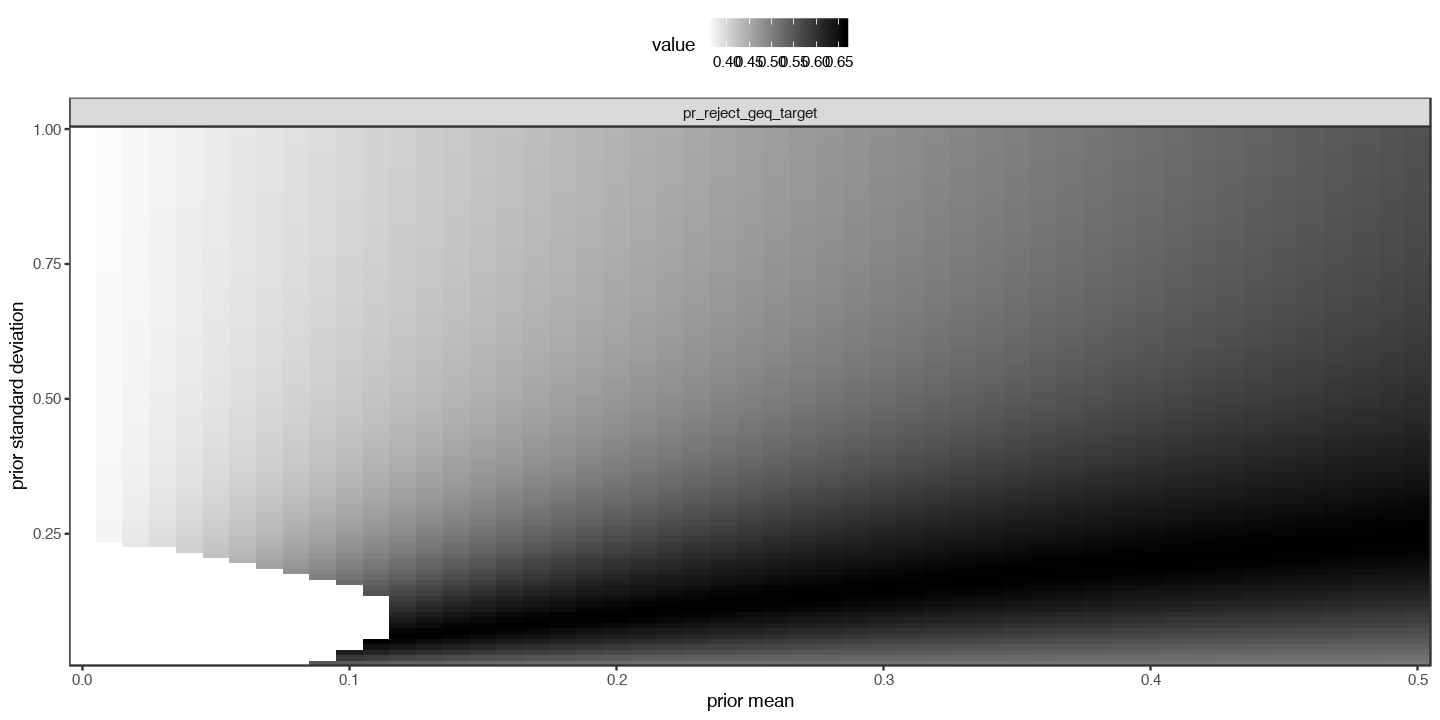

In [53]:
options(repr.plot.width = 12, repr.plot.height = 6)

tbl_grid %>% 
    filter(probability == "pr_reject_geq_target") %>%
    ggplot() +
        aes(mu, tau, fill = value) +
        geom_raster() +
        # geom_contour() + # geom_raster leads to some pdf viewers interpolating, do not want that!
        scale_fill_gradient(low = '#FFFFFF', high = '#000000') +
        coord_cartesian(expand = FALSE) +
        xlab('prior mean') +
        ylab('prior standard deviation') +
        facet_wrap(~probability) +
        theme_bw() +
        theme(
            panel.grid      = element_blank(),
            panel.spacing   = unit(1.25, 'lines'),
            legend.position = 'top'
        )

# save plot as pdf
ggsave('../latex/figures/quantile-vs-ep.pdf', width = 8, height = 4)